# UIDAI DATA HACKTHON 2026

- Submitted By UIDAI_2022

## Imports

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

## Enrollment Data Processing

In [78]:
enrol_folder = r"E:\UIDAI\api_data_aadhar_enrolment"
enrol_files = [f for f in os.listdir(enrol_folder) if f.endswith('.csv')]
enrol_df = pd.concat([pd.read_csv(os.path.join(enrol_folder, f)) for f in enrol_files], ignore_index=True)
enrol_df['date'] = pd.to_datetime(enrol_df['date'], format='%d-%m-%Y')
enrol_df['total_enrol'] = enrol_df['age_0_5'] + enrol_df['age_5_17'] + enrol_df['age_18_greater']

In [79]:
enrol_df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,86
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,51


## Biometric Data Processing

In [80]:
bio_folder = r"E:\UIDAI\api_data_aadhar_biometric"
bio_files = [f for f in os.listdir(bio_folder) if f.endswith('.csv')]
bio_df = pd.concat([pd.read_csv(os.path.join(bio_folder, f)) for f in bio_files], ignore_index=True)
bio_df['date'] = pd.to_datetime(bio_df['date'], format='%d-%m-%Y')
bio_df['total_bio'] = bio_df['bio_age_5_17'] + bio_df['bio_age_17_']

In [81]:
bio_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,total_bio
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,857
1,2025-03-01,Bihar,Madhepura,852121,144,369,513
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,1734
3,2025-03-01,Bihar,Bhojpur,802158,256,980,1236
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,1086


## Feature Engineering and Merging

We merge the datasets and create relative metrics. Using ratios like bio_intensity is more effective than raw counts because it accounts for population differences across pincodes.

In [82]:
enrol_agg = enrol_df.groupby(['state', 'district', 'pincode']).agg({
    'total_enrol': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum'
}).reset_index()
bio_agg = bio_df.groupby(['state', 'district', 'pincode'])['total_bio'].sum().reset_index()
merged = enrol_agg.merge(bio_agg, on=['state', 'district', 'pincode'], how='left').fillna(0)
merged['bio_intensity'] = merged['total_bio'] / (merged['total_enrol'] + 1)
merged['child_ratio'] = (merged['age_0_5'] + merged['age_5_17']) / (merged['total_enrol'] + 1)

## Distribution Analysis (Biometric Updates)

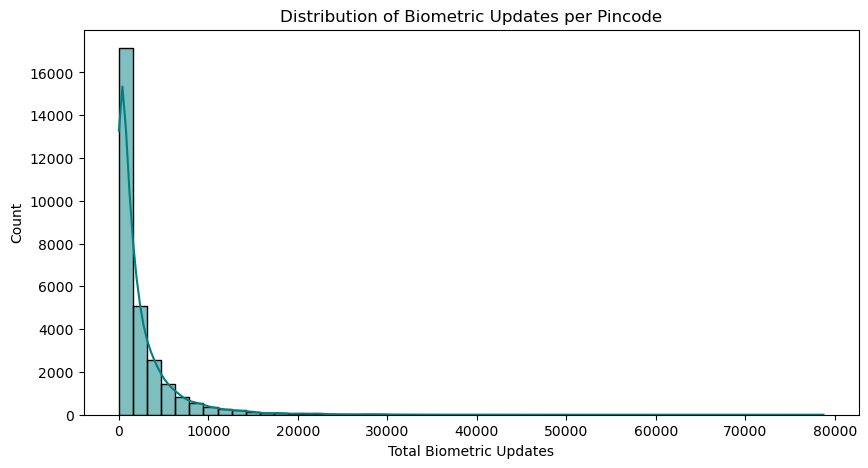

In [83]:
plt.figure(figsize=(10, 5))
sns.histplot(merged['total_bio'], bins=50, kde=True, color='teal')
plt.title('Distribution of Biometric Updates per Pincode')
plt.xlabel('Total Biometric Updates')
plt.show()


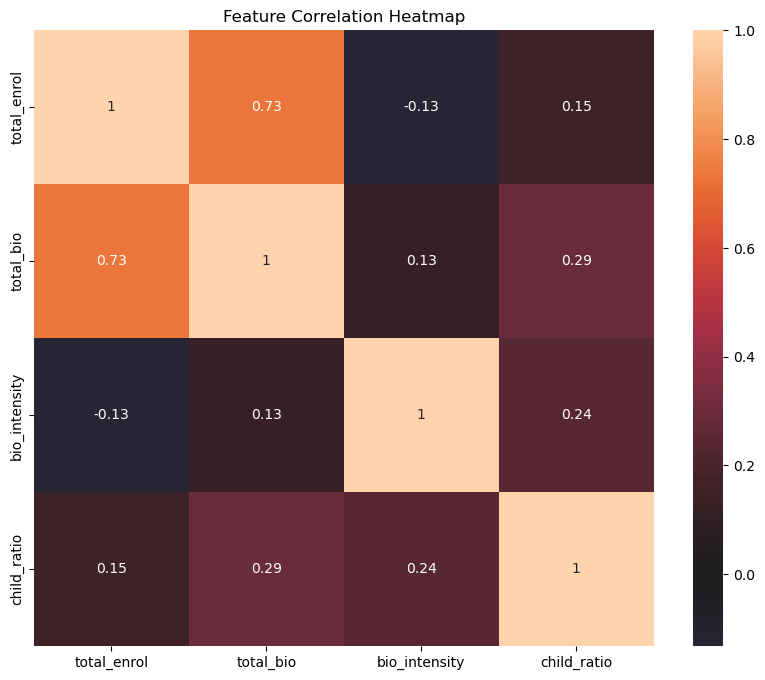

In [84]:
corr_features = ['total_enrol', 'total_bio', 'bio_intensity', 'child_ratio']
plt.figure(figsize=(10, 8))
sns.heatmap(merged[corr_features].corr(), annot=True, center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## Anomaly Detection

- -1 : These are data points that the model has identified as unusual or "anomalies"
-  1 : These are the data points considered "normal" 

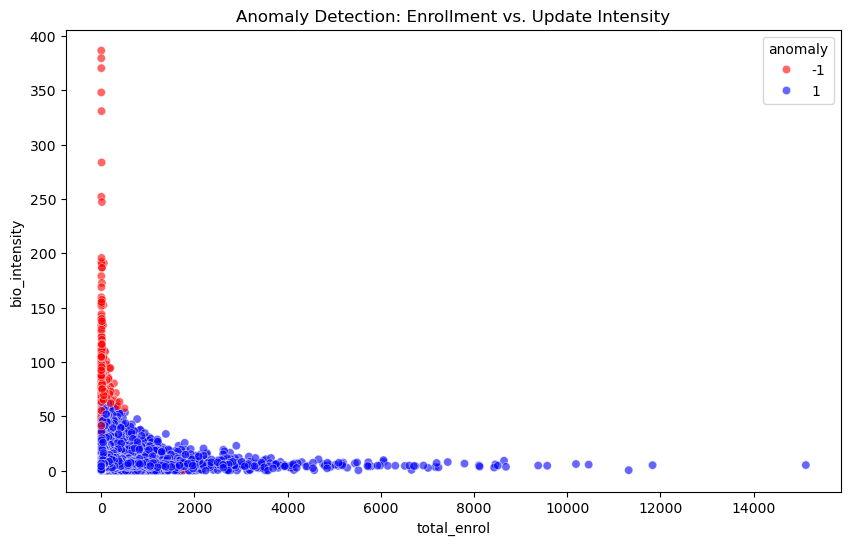

In [85]:
scaler = RobustScaler()
X = scaler.fit_transform(merged[['bio_intensity', 'child_ratio']])
model = IsolationForest(contamination=0.05, random_state=42)
merged['anomaly'] = model.fit_predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='total_enrol', y='bio_intensity', 
                hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title('Anomaly Detection: Enrollment vs. Update Intensity')
plt.show()

In [86]:
print('--- UIDAI OPERATIONAL ANOMALY REPORT ---')
print(f"Total Pincodes Scanned: {len(merged)}")
print(f"Total Anomalous Locations Identified: {merged['anomaly'].sum()}")
print(f"National Avg Biometric Intensity: {merged['bio_intensity'].mean():.2f}")
print("\nTop 5 Districts with High-Intensity Anomalies:")
print(merged[merged['anomaly'] == 1].groupby('district')['bio_intensity'].mean().sort_values(ascending=False).head(5))

--- UIDAI OPERATIONAL ANOMALY REPORT ---
Total Pincodes Scanned: 28986
Total Anomalous Locations Identified: 26086
National Avg Biometric Intensity: 17.94

Top 5 Districts with High-Intensity Anomalies:
district
Mansa         49.488409
Gadchiroli    48.537668
Amravati      47.777269
Yavatmal      45.865520
Thoubal       45.179836
Name: bio_intensity, dtype: float64
